In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 

plt.style.use('ggplot')

In [2]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
    # add credential here)

# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

test_format1 = pd.read_csv(body)
test_format1.head()


# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

user_log_format1 = pd.read_csv(body)
user_log_format1.head()

# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

user_info_format1 = pd.read_csv(body)
user_info_format1.head()

# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

train_format1 = pd.read_csv(body)
train_format1.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


## data clearning

In [3]:
# reduce the size the file and change the datatype to float32/datetime
# fillna - brand_id fill in 0
# fillna - gender fill in 2 as unknown
# fillna - age_range fill in 0 as unknown
# rename - since seller_id and merchant_id are the same, we need to merge them

user_log_format1.rename(columns={'seller_id':'merchant_id'}, inplace=True)
user_log_format1['user_id'] = user_log_format1['user_id'].astype('int32')
user_log_format1['merchant_id'] = user_log_format1['merchant_id'].astype('int32')
user_log_format1['item_id'] = user_log_format1['item_id'].astype('int32')
user_log_format1['cat_id'] = user_log_format1['cat_id'].astype('int32')
user_log_format1['brand_id'].fillna(0, inplace=True)
user_log_format1['brand_id'] = user_log_format1['brand_id'].astype('int32')
user_log_format1['time_stamp'] = pd.to_datetime(user_log_format1['time_stamp'], format='%H%M')

In [4]:
# combine data to 1 training dataframe

train_format1 = train_format1.merge(user_info_format1, on='user_id', how='left')
train_format1['age_range'].fillna(0, inplace=True)
# 0:female, 1:male, 2:unknown
train_format1['gender'].fillna(2, inplace=True)
train_format1['age_range'] = train_format1['age_range'].astype('int8')
train_format1['gender'] = train_format1['gender'].astype('int8')
train_format1['label'] = train_format1['label'].astype('str')
train_format1['user_id'] = train_format1['user_id'].astype('int32')
train_format1['merchant_id'] = train_format1['merchant_id'].astype('int32')

In [5]:
train_format1['label'] = train_format1['label'].astype('int64')

In [6]:
train_format1.head()

,user_id,merchant_id,label,age_range,gender
0,34176,3906,0,6,0
1,34176,121,0,6,0
2,34176,4356,1,6,0
3,34176,2217,0,6,0
4,230784,4818,0,0,0


Index(['age_range', 'sum', 'mean'], dtype='object')


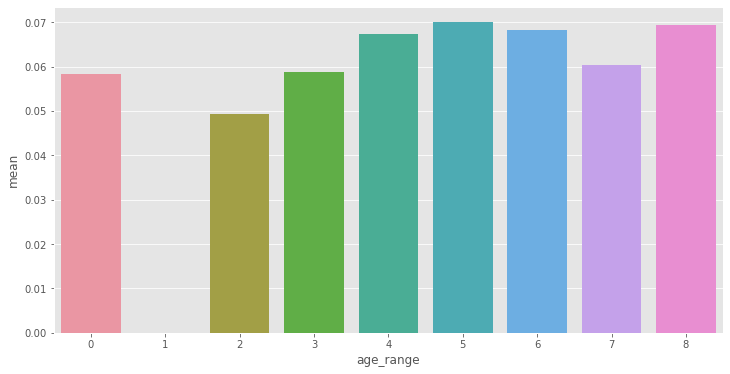

In [7]:
def plot_B(df,col,name):
    plt.figure(figsize=(12,6))
    data = df.groupby(col)['label'].agg(['sum','mean']).reset_index()
    print(data.columns)
    sns.barplot(x=col, y=name, data=data)
#     sns.barplot(x=col, y='sum', data=data)

plot_B(train_format1,'age_range','mean')

Index(['gender', 'sum', 'mean'], dtype='object')


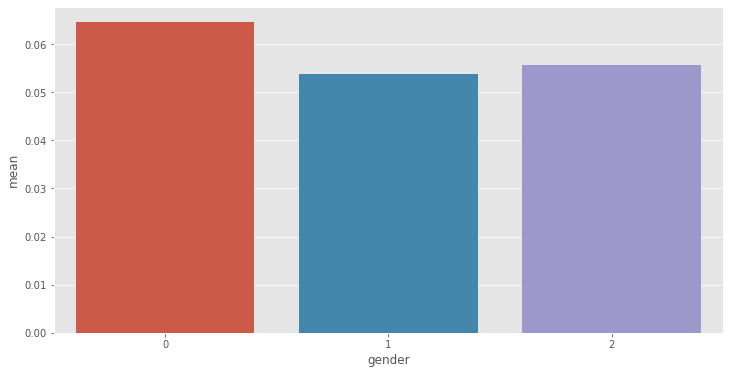

In [8]:
def plot_B(df,col,name):
    plt.figure(figsize=(12,6))
    data = df.groupby(col)['label'].agg(['sum','mean']).reset_index()
    print(data.columns)
    sns.barplot(x=col, y=name, data=data)
#     sns.barplot(x=col, y='sum', data=data)

plot_B(train_format1,'gender','mean')

## feature engineering

In [9]:
# features of users

groups = user_log_format1.groupby(['user_id'])

# u1 - how many times user have interaction with different merchants
temp = groups.size().reset_index().rename(columns={0:'u1'})
train_format1 = train_format1.merge(temp, on='user_id', how='left')

# u3 - for each user, the number of distinct merchant
temp = groups['merchant_id'].agg([('u3', 'nunique')]).reset_index()
train_format1 = train_format1.merge(temp, on='user_id', how='left')

# u6-9 - for each user, the number of action_type equals to 0,1,2,3(visit, click, add to cart, buy)
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'u6', 1:'u7', 2:'u8', 3:'u9'})
train_format1 = train_format1.merge(temp, on='user_id', how='left')

# u10 - the number of unique time periods of a user
temp = groups['time_stamp'].agg([('u10', 'nunique')]).reset_index()
train_format1 = train_format1.merge(temp, on='user_id', how='left')

# u11 - time interval of a user
temp = groups['time_stamp'].agg([('F_time', 'min'), ('L_time', 'max')]).reset_index()
temp['u11'] = (temp['L_time'] - temp['F_time']).dt.seconds/3600
train_format1 = train_format1.merge(temp[['user_id', 'u11']], on='user_id', how='left')

In [10]:
train_format1.head()

,user_id,merchant_id,label,age_range,gender,u1,u3,u6,u7,u8,u9,u10,u11
0,34176,3906,0,6,0,451,109,410.0,NaN,34.0,7.0,47,5.833333
1,34176,121,0,6,0,451,109,410.0,NaN,34.0,7.0,47,5.833333
2,34176,4356,1,6,0,451,109,410.0,NaN,34.0,7.0,47,5.833333
3,34176,2217,0,6,0,451,109,410.0,NaN,34.0,7.0,47,5.833333
4,230784,4818,0,0,0,54,20,47.0,NaN,7.0,NaN,16,5.166667


In [11]:
# features of merchants

groups = user_log_format1.groupby(['merchant_id'])

# m1 - how many times a merchant is visited, clicked ..
temp = groups.size().reset_index().rename(columns={0:'m1'})
train_format1 = train_format1.merge(temp, on='merchant_id', how='left')

# m6-9 - counts for each action type
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'m6', 1:'m7', 2:'m8', 3:'m9'})
train_format1 = train_format1.merge(temp, on='merchant_id', how='left')

In [12]:
train_format1.head()

,user_id,merchant_id,label,age_range,gender,u1,u3,u6,u7,u8,u9,u10,u11,m1,m6,m7,m8,m9
0,34176,3906,0,6,0,451,109,410.0,NaN,34.0,7.0,47,5.833333,16269,14870.0,28.0,410.0,961.0
1,34176,121,0,6,0,451,109,410.0,NaN,34.0,7.0,47,5.833333,79865,72265.0,121.0,4780.0,2699.0
2,34176,4356,1,6,0,451,109,410.0,NaN,34.0,7.0,47,5.833333,7269,6094.0,16.0,963.0,196.0
3,34176,2217,0,6,0,451,109,410.0,NaN,34.0,7.0,47,5.833333,60202,52230.0,101.0,3721.0,4150.0
4,230784,4818,0,0,0,54,20,47.0,NaN,7.0,NaN,16,5.166667,48089,43268.0,129.0,2733.0,1959.0


In [13]:
# features of user+merchant

groups = user_log_format1.groupby(['user_id', 'merchant_id'])

# um1 - how many times a user interacted with a certain merchant
temp = groups.size().reset_index().rename(columns={0:'um1'})
train_format1 = train_format1.merge(temp, on=['user_id', 'merchant_id'], how='left')

# um2-4 - counts for item_id,cat_id and brand_id a user interacted with a certain merchant
temp = groups['item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id':'um2', 'cat_id':'um3', 'brand_id':'um4'}) 
train_format1 = train_format1.merge(temp, on=['user_id', 'merchant_id'], how='left')

# um5-8 - counts for 4 action types a user interacted with a certain merchant
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'um5', 1:'um6', 2:'um7', 3:'um8'})
train_format1 = train_format1.merge(temp, on=['user_id', 'merchant_id'], how='left')


/tmp/wsuser/ipykernel_132/620209421.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = groups['item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id':'um2', 'cat_id':'um3', 'brand_id':'um4'})


In [14]:
train_format1.head()

,user_id,merchant_id,label,age_range,gender,u1,u3,u6,u7,u8,...,m8,m9,um1,um2,um3,um4,um5,um6,um7,um8
0,34176,3906,0,6,0,451,109,410.0,NaN,34.0,...,410.0,961.0,39,20,6,1,36.0,NaN,1.0,2.0
1,34176,121,0,6,0,451,109,410.0,NaN,34.0,...,4780.0,2699.0,14,1,1,1,13.0,NaN,1.0,NaN
2,34176,4356,1,6,0,451,109,410.0,NaN,34.0,...,963.0,196.0,18,2,1,1,12.0,NaN,6.0,NaN
3,34176,2217,0,6,0,451,109,410.0,NaN,34.0,...,3721.0,4150.0,2,1,1,1,1.0,NaN,1.0,NaN
4,230784,4818,0,0,0,54,20,47.0,NaN,7.0,...,2733.0,1959.0,8,1,1,1,7.0,NaN,1.0,NaN


In [15]:
# normalization + fillna
train_format1.fillna(0,inplace=True)

In [16]:
train_format = train_format1.copy()

Index(['u6', 'sum', 'mean'], dtype='object')


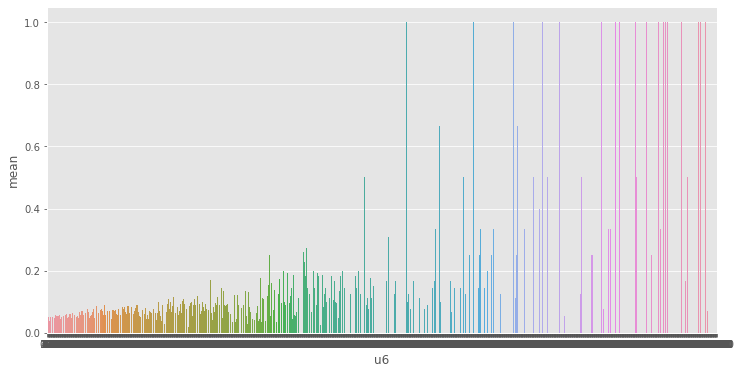

In [17]:
plot_B(train_format1,'u6','mean')

Index(['u8', 'sum', 'mean'], dtype='object')


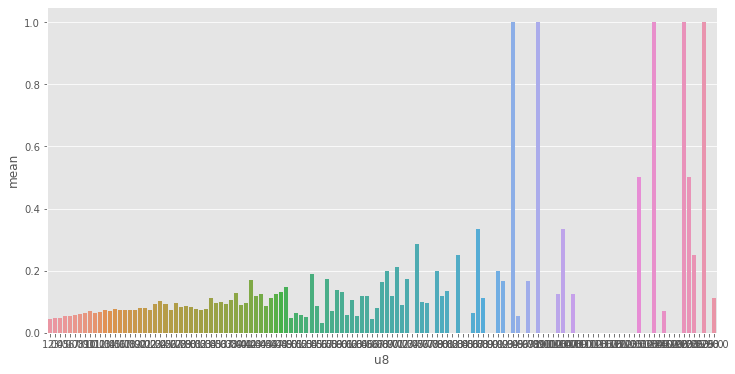

In [18]:
plot_B(train_format1,'u8','mean')

In [19]:
def norm(df):
    for i in df.columns[3:]:
        mean_ = df[i].mean()
        std_ = df[i].std()
        df[i] = (df[i] - mean_) / std_
    
norm(train_format1)
train_format1.head()

,user_id,merchant_id,label,age_range,gender,u1,u3,u6,u7,u8,...,m8,m9,um1,um2,um3,um4,um5,um6,um7,um8
0,34176,3906,0,1.579258,-0.651202,1.496842,1.997470,1.504636,-0.204825,2.835969,...,-0.716456,-0.309107,1.421635,1.963498,2.209934,-0.272386,1.414559,-0.112848,-0.394716,1.131803
1,34176,121,0,1.579258,-0.651202,1.496842,1.997470,1.504636,-0.204825,2.835969,...,0.582365,-0.075312,0.160135,-0.424981,-0.472366,-0.272386,0.206116,-0.112848,-0.394716,-0.271127
2,34176,4356,1,1.579258,-0.651202,1.496842,1.997470,1.504636,-0.204825,2.835969,...,-0.552097,-0.412015,0.361975,-0.299271,-0.472366,-0.272386,0.153575,-0.112848,5.423893,-0.271127
3,34176,2217,0,1.579258,-0.651202,1.496842,1.997470,1.504636,-0.204825,2.835969,...,0.267617,0.119876,-0.445384,-0.424981,-0.472366,-0.272386,-0.424376,-0.112848,-0.394716,-0.271127
4,230784,4818,0,-1.521474,-0.651202,-0.429089,-0.424466,-0.416779,-0.204825,-0.191453,...,-0.026030,-0.174857,-0.142625,-0.424981,-0.472366,-0.272386,-0.109130,-0.112848,-0.394716,-0.271127


In [20]:
featuresName = list(train_format1.columns[3:])

In [21]:
train_format1.corr()

,user_id,merchant_id,label,age_range,gender,u1,u3,u6,u7,u8,...,m8,m9,um1,um2,um3,um4,um5,um6,um7,um8
user_id,1.000000,0.001527,-0.001317,0.003975,0.001673,0.003000,0.001469,0.003589,-0.004513,0.002876,...,-0.000069,-0.000036,-0.001556,-0.002708,-0.002889,-0.004319,-0.001467,-0.001697,-0.000935,-0.001237
merchant_id,0.001527,1.000000,0.001175,-0.016926,0.007070,-0.009449,-0.005394,-0.009809,0.001683,-0.011545,...,0.093309,0.091813,0.001208,0.009177,0.011723,-0.027634,0.000508,0.004601,0.010971,0.002730
label,-0.001317,0.001175,1.000000,0.017527,-0.018771,0.035968,0.016022,0.034649,-0.007727,0.049301,...,0.048117,0.036797,0.081418,0.099158,0.102606,0.012764,0.077081,-0.003404,0.084347,0.052391
age_range,0.003975,-0.016926,0.017527,1.000000,-0.002918,0.097995,0.094286,0.096085,-0.037697,0.149465,...,-0.014263,-0.014162,0.022355,0.031202,0.024782,0.014969,0.021515,-0.032132,0.042564,0.002604
gender,0.001673,0.007070,-0.018771,-0.002918,1.000000,-0.058206,-0.064972,-0.053821,0.027090,-0.036912,...,-0.050920,-0.067864,-0.033720,-0.050054,-0.049373,0.026674,-0.030732,0.029207,-0.028175,-0.045782
u1,0.003000,-0.009449,0.035968,0.097995,-0.058206,1.000000,0.802782,0.995219,0.008659,0.548890,...,0.047220,0.062680,0.316771,0.299357,0.245729,0.038609,0.310562,-0.017000,0.060450,0.223373
u3,0.001469,-0.005394,0.016022,0.094286,-0.064972,0.802782,1.000000,0.788885,0.006163,0.533844,...,0.015648,0.026651,0.151991,0.144410,0.129160,0.011111,0.148091,-0.027687,-0.002590,0.141398
u6,0.003589,-0.009809,0.034649,0.096085,-0.053821,0.995219,0.788885,1.000000,0.008008,0.522610,...,0.045908,0.061930,0.323654,0.304011,0.246497,0.038945,0.320028,-0.016828,0.055958,0.195368
u7,-0.004513,0.001683,-0.007727,-0.037697,0.027090,0.008659,0.006163,0.008008,1.000000,-0.014491,...,0.010102,0.011962,0.021845,0.016121,0.020060,0.129935,0.018942,0.502366,-0.006580,-0.019390
u8,0.002876,-0.011545,0.049301,0.149465,-0.036912,0.548890,0.533844,0.522610,-0.014491,1.000000,...,0.034659,0.021256,0.068567,0.088400,0.110392,0.029066,0.061267,-0.036698,0.159846,0.044269


## Model Training - spark Random Forest

In [23]:
!pip install pyspark==3.2

In [24]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [25]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/22 05:21:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [26]:
sparkDF = spark.createDataFrame(train_format1) 

In [27]:
sparkDF.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_id: long (nullable = true)
 |-- label: long (nullable = true)
 |-- age_range: double (nullable = true)
 |-- gender: double (nullable = true)
 |-- u1: double (nullable = true)
 |-- u3: double (nullable = true)
 |-- u6: double (nullable = true)
 |-- u7: double (nullable = true)
 |-- u8: double (nullable = true)
 |-- u9: double (nullable = true)
 |-- u10: double (nullable = true)
 |-- u11: double (nullable = true)
 |-- m1: double (nullable = true)
 |-- m6: double (nullable = true)
 |-- m7: double (nullable = true)
 |-- m8: double (nullable = true)
 |-- m9: double (nullable = true)
 |-- um1: double (nullable = true)
 |-- um2: double (nullable = true)
 |-- um3: double (nullable = true)
 |-- um4: double (nullable = true)
 |-- um5: double (nullable = true)
 |-- um6: double (nullable = true)
 |-- um7: double (nullable = true)
 |-- um8: double (nullable = true)



In [28]:
# sparkDF.show()
import gc
gc.collect()

383077

In [29]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols=featuresName,outputCol='features')###YOUR_CODE_GOES_HERE###"

In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(sparkDF)
# featureIndexer =\
#     VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(sparkDF)
(trainingData, testData) = sparkDF.randomSplit([0.7, 0.3])

22/06/22 05:22:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/06/22 05:22:29 WARN TaskSetManager: Stage 0 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.


In [31]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=200)

In [32]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [33]:
pipeline = Pipeline(stages=[labelIndexer, vectorAssembler, rf, labelConverter])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)

22/06/22 05:22:33 WARN TaskSetManager: Stage 3 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:22:34 WARN TaskSetManager: Stage 4 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:22:36 WARN TaskSetManager: Stage 5 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:22:38 WARN TaskSetManager: Stage 7 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:22:42 WARN TaskSetManager: Stage 9 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:22:43 WARN TaskSetManager: Stage 11 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:22:45 WARN TaskSetManager: Stage 13 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/0

In [34]:
predictions.select("predictedLabel", "label", "features").show(5)

22/06/22 05:22:54 WARN TaskSetManager: Stage 17 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.


+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    0|[0.54568061486510...|
|             0|    0|[1.06246936597663...|
|             0|    0|[0.02889186375356...|
|             0|    0|[0.02889186375356...|
|             0|    0|[-0.4878968873579...|
+--------------+-----+--------------------+
only showing top 5 rows



In [35]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

22/06/22 05:22:54 WARN TaskSetManager: Stage 18 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.


Test Error = 0.0618789
RandomForestClassificationModel: uid=RandomForestClassifier_0d14c10457df, numTrees=200, numClasses=2, numFeatures=23


In [36]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)
print('Test Area Under Roc',evaluator.evaluate(predictions))

22/06/22 05:22:57 WARN TaskSetManager: Stage 20 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:00 WARN TaskSetManager: Stage 31 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.


Test Area Under Roc 0.6267048284602211


# Gradient Boosting

In [37]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="features", maxIter=100)

pipeline = Pipeline(stages=[labelIndexer, vectorAssembler, gbt])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)

# Select (prediction, true label) and compute testb error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

22/06/22 05:23:03 WARN TaskSetManager: Stage 42 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:03 WARN TaskSetManager: Stage 43 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:04 WARN TaskSetManager: Stage 44 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:04 WARN TaskSetManager: Stage 46 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:06 WARN TaskSetManager: Stage 48 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:06 WARN TaskSetManager: Stage 50 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:06 WARN TaskSetManager: Stage 52 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.

22/06/22 05:23:15 WARN TaskSetManager: Stage 156 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:15 WARN TaskSetManager: Stage 158 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:16 WARN TaskSetManager: Stage 160 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:16 WARN TaskSetManager: Stage 162 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:16 WARN TaskSetManager: Stage 164 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:16 WARN TaskSetManager: Stage 166 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:16 WARN TaskSetManager: Stage 168 contains a task of very large size (13846 KiB). The maximum recommended task size is 10

22/06/22 05:23:24 WARN TaskSetManager: Stage 272 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:25 WARN TaskSetManager: Stage 274 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:25 WARN TaskSetManager: Stage 276 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:25 WARN TaskSetManager: Stage 278 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:25 WARN TaskSetManager: Stage 280 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:25 WARN TaskSetManager: Stage 282 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:25 WARN TaskSetManager: Stage 284 contains a task of very large size (13846 KiB). The maximum recommended task size is 10

22/06/22 05:23:33 WARN TaskSetManager: Stage 386 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:33 WARN TaskSetManager: Stage 388 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:33 WARN TaskSetManager: Stage 390 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:34 WARN TaskSetManager: Stage 392 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:34 WARN TaskSetManager: Stage 394 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:34 WARN TaskSetManager: Stage 396 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:34 WARN TaskSetManager: Stage 398 contains a task of very large size (13846 KiB). The maximum recommended task size is 10

22/06/22 05:23:43 WARN TaskSetManager: Stage 502 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:43 WARN TaskSetManager: Stage 504 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:43 WARN TaskSetManager: Stage 506 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:43 WARN TaskSetManager: Stage 508 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:43 WARN TaskSetManager: Stage 510 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:44 WARN TaskSetManager: Stage 512 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:44 WARN TaskSetManager: Stage 514 contains a task of very large size (13847 KiB). The maximum recommended task size is 10

22/06/22 05:23:52 WARN TaskSetManager: Stage 616 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:52 WARN TaskSetManager: Stage 618 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:52 WARN TaskSetManager: Stage 620 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:52 WARN TaskSetManager: Stage 622 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:53 WARN TaskSetManager: Stage 624 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:53 WARN TaskSetManager: Stage 626 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:23:53 WARN TaskSetManager: Stage 628 contains a task of very large size (13847 KiB). The maximum recommended task size is 10

22/06/22 05:24:01 WARN TaskSetManager: Stage 732 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:02 WARN TaskSetManager: Stage 734 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:02 WARN TaskSetManager: Stage 736 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:02 WARN TaskSetManager: Stage 738 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:02 WARN TaskSetManager: Stage 740 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:02 WARN TaskSetManager: Stage 742 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:02 WARN TaskSetManager: Stage 744 contains a task of very large size (13848 KiB). The maximum recommended task size is 10

22/06/22 05:24:12 WARN TaskSetManager: Stage 846 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:12 WARN TaskSetManager: Stage 848 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:12 WARN TaskSetManager: Stage 850 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:12 WARN TaskSetManager: Stage 852 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:12 WARN TaskSetManager: Stage 854 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:12 WARN TaskSetManager: Stage 856 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:13 WARN TaskSetManager: Stage 858 contains a task of very large size (13848 KiB). The maximum recommended task size is 10

22/06/22 05:24:22 WARN TaskSetManager: Stage 962 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:22 WARN TaskSetManager: Stage 964 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:22 WARN TaskSetManager: Stage 966 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:22 WARN TaskSetManager: Stage 968 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:22 WARN TaskSetManager: Stage 970 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:23 WARN TaskSetManager: Stage 972 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:23 WARN TaskSetManager: Stage 974 contains a task of very large size (13848 KiB). The maximum recommended task size is 10

Test Error = 0.0620314
GBTClassificationModel: uid = GBTClassifier_7b1e43b7ccce, numTrees=100, numClasses=2, numFeatures=23


In [38]:
from pyspark.ml.classification import RandomForestClassifier
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)
print('Test Area Under Roc',evaluator.evaluate(predictions))

22/06/22 05:24:30 WARN TaskSetManager: Stage 1048 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:24:32 WARN TaskSetManager: Stage 1059 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.


Test Area Under Roc 0.6568406569973364


In [39]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="features", maxIter=50)

pipeline = Pipeline(stages=[labelIndexer, vectorAssembler, gbt])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)

# Select (prediction, true label) and compute testb error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)
print('Test Area Under Roc',evaluator.evaluate(predictions))

22/06/22 05:25:05 WARN TaskSetManager: Stage 1070 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:06 WARN TaskSetManager: Stage 1071 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:06 WARN TaskSetManager: Stage 1072 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:07 WARN TaskSetManager: Stage 1074 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:08 WARN TaskSetManager: Stage 1076 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:08 WARN TaskSetManager: Stage 1078 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:08 WARN TaskSetManager: Stage 1080 contains a task of very large size (13845 KiB). The maximum recommended task siz

22/06/22 05:25:17 WARN TaskSetManager: Stage 1184 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:17 WARN TaskSetManager: Stage 1186 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:17 WARN TaskSetManager: Stage 1188 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:17 WARN TaskSetManager: Stage 1190 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:17 WARN TaskSetManager: Stage 1192 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:17 WARN TaskSetManager: Stage 1194 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:18 WARN TaskSetManager: Stage 1196 contains a task of very large size (13846 KiB). The maximum recommended task siz

22/06/22 05:25:26 WARN TaskSetManager: Stage 1300 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:26 WARN TaskSetManager: Stage 1302 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:26 WARN TaskSetManager: Stage 1304 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:26 WARN TaskSetManager: Stage 1306 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:26 WARN TaskSetManager: Stage 1308 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:26 WARN TaskSetManager: Stage 1310 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:27 WARN TaskSetManager: Stage 1312 contains a task of very large size (13846 KiB). The maximum recommended task siz

22/06/22 05:25:35 WARN TaskSetManager: Stage 1414 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:35 WARN TaskSetManager: Stage 1416 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:36 WARN TaskSetManager: Stage 1418 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:36 WARN TaskSetManager: Stage 1420 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:36 WARN TaskSetManager: Stage 1422 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:36 WARN TaskSetManager: Stage 1424 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:36 WARN TaskSetManager: Stage 1426 contains a task of very large size (13846 KiB). The maximum recommended task siz

22/06/22 05:25:45 WARN TaskSetManager: Stage 1530 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:45 WARN TaskSetManager: Stage 1532 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:45 WARN TaskSetManager: Stage 1534 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:45 WARN TaskSetManager: Stage 1536 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:45 WARN TaskSetManager: Stage 1538 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:45 WARN TaskSetManager: Stage 1540 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:46 WARN TaskSetManager: Stage 1542 contains a task of very large size (13847 KiB). The maximum recommended task siz

Test Error = 0.0619297


22/06/22 05:25:49 WARN TaskSetManager: Stage 1576 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:25:51 WARN TaskSetManager: Stage 1587 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.


Test Area Under Roc 0.647667886668706


In [42]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="features", maxIter=200)

pipeline = Pipeline(stages=[labelIndexer, vectorAssembler, gbt])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)

# Select (prediction, true label) and compute testb error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)
print('Test Area Under Roc',evaluator.evaluate(predictions))

22/06/22 05:31:10 WARN TaskSetManager: Stage 4154 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:11 WARN TaskSetManager: Stage 4155 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:11 WARN TaskSetManager: Stage 4156 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:12 WARN TaskSetManager: Stage 4158 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:13 WARN TaskSetManager: Stage 4160 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:13 WARN TaskSetManager: Stage 4162 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:13 WARN TaskSetManager: Stage 4164 contains a task of very large size (13845 KiB). The maximum recommended task siz

22/06/22 05:31:20 WARN TaskSetManager: Stage 4266 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:21 WARN TaskSetManager: Stage 4268 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:21 WARN TaskSetManager: Stage 4270 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:21 WARN TaskSetManager: Stage 4272 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:21 WARN TaskSetManager: Stage 4274 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:21 WARN TaskSetManager: Stage 4276 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:21 WARN TaskSetManager: Stage 4278 contains a task of very large size (13846 KiB). The maximum recommended task siz

22/06/22 05:31:29 WARN TaskSetManager: Stage 4380 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:29 WARN TaskSetManager: Stage 4382 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:29 WARN TaskSetManager: Stage 4384 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:29 WARN TaskSetManager: Stage 4386 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:29 WARN TaskSetManager: Stage 4388 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:30 WARN TaskSetManager: Stage 4390 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:30 WARN TaskSetManager: Stage 4392 contains a task of very large size (13846 KiB). The maximum recommended task siz

22/06/22 05:31:37 WARN TaskSetManager: Stage 4494 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:37 WARN TaskSetManager: Stage 4496 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:37 WARN TaskSetManager: Stage 4498 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:38 WARN TaskSetManager: Stage 4500 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:38 WARN TaskSetManager: Stage 4502 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:38 WARN TaskSetManager: Stage 4504 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:38 WARN TaskSetManager: Stage 4506 contains a task of very large size (13846 KiB). The maximum recommended task siz

22/06/22 05:31:46 WARN TaskSetManager: Stage 4608 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:46 WARN TaskSetManager: Stage 4610 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:46 WARN TaskSetManager: Stage 4612 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:46 WARN TaskSetManager: Stage 4614 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:46 WARN TaskSetManager: Stage 4616 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:46 WARN TaskSetManager: Stage 4618 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:47 WARN TaskSetManager: Stage 4620 contains a task of very large size (13847 KiB). The maximum recommended task siz

22/06/22 05:31:55 WARN TaskSetManager: Stage 4724 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:55 WARN TaskSetManager: Stage 4726 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:55 WARN TaskSetManager: Stage 4728 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:55 WARN TaskSetManager: Stage 4730 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:55 WARN TaskSetManager: Stage 4732 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:56 WARN TaskSetManager: Stage 4734 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:31:56 WARN TaskSetManager: Stage 4736 contains a task of very large size (13847 KiB). The maximum recommended task siz

22/06/22 05:32:05 WARN TaskSetManager: Stage 4838 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:05 WARN TaskSetManager: Stage 4840 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:05 WARN TaskSetManager: Stage 4842 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:05 WARN TaskSetManager: Stage 4844 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:05 WARN TaskSetManager: Stage 4846 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:06 WARN TaskSetManager: Stage 4848 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:06 WARN TaskSetManager: Stage 4850 contains a task of very large size (13848 KiB). The maximum recommended task siz

22/06/22 05:32:15 WARN TaskSetManager: Stage 4954 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:15 WARN TaskSetManager: Stage 4956 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:15 WARN TaskSetManager: Stage 4958 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:16 WARN TaskSetManager: Stage 4960 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:16 WARN TaskSetManager: Stage 4962 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:16 WARN TaskSetManager: Stage 4964 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:16 WARN TaskSetManager: Stage 4966 contains a task of very large size (13848 KiB). The maximum recommended task siz

22/06/22 05:32:25 WARN TaskSetManager: Stage 5068 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:25 WARN TaskSetManager: Stage 5070 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:25 WARN TaskSetManager: Stage 5072 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:25 WARN TaskSetManager: Stage 5074 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:25 WARN TaskSetManager: Stage 5076 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:25 WARN TaskSetManager: Stage 5078 contains a task of very large size (13848 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:26 WARN TaskSetManager: Stage 5080 contains a task of very large size (13848 KiB). The maximum recommended task siz

22/06/22 05:32:36 WARN TaskSetManager: Stage 5184 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:36 WARN TaskSetManager: Stage 5186 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:36 WARN TaskSetManager: Stage 5188 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:36 WARN TaskSetManager: Stage 5190 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:37 WARN TaskSetManager: Stage 5192 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:37 WARN TaskSetManager: Stage 5194 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:37 WARN TaskSetManager: Stage 5196 contains a task of very large size (13849 KiB). The maximum recommended task siz

22/06/22 05:32:46 WARN TaskSetManager: Stage 5298 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:47 WARN TaskSetManager: Stage 5300 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:47 WARN TaskSetManager: Stage 5302 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:47 WARN TaskSetManager: Stage 5304 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:47 WARN TaskSetManager: Stage 5306 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:47 WARN TaskSetManager: Stage 5308 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:47 WARN TaskSetManager: Stage 5310 contains a task of very large size (13849 KiB). The maximum recommended task siz

22/06/22 05:32:57 WARN TaskSetManager: Stage 5414 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:57 WARN TaskSetManager: Stage 5416 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:58 WARN TaskSetManager: Stage 5418 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:58 WARN TaskSetManager: Stage 5420 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:58 WARN TaskSetManager: Stage 5422 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:58 WARN TaskSetManager: Stage 5424 contains a task of very large size (13849 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:32:58 WARN TaskSetManager: Stage 5426 contains a task of very large size (13849 KiB). The maximum recommended task siz

22/06/22 05:33:06 WARN DAGScheduler: Broadcasting large task binary with size 1027.0 KiB
22/06/22 05:33:06 WARN TaskSetManager: Stage 5506 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1029.5 KiB
22/06/22 05:33:07 WARN TaskSetManager: Stage 5508 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1030.0 KiB
22/06/22 05:33:07 WARN TaskSetManager: Stage 5510 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1030.7 KiB
22/06/22 05:33:07 WARN TaskSetManager: Stage 5512 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:07 WARN DAGScheduler: Broadcasting large task bin

22/06/22 05:33:13 WARN DAGScheduler: Broadcasting large task binary with size 1078.4 KiB
22/06/22 05:33:13 WARN TaskSetManager: Stage 5578 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1078.9 KiB
22/06/22 05:33:14 WARN TaskSetManager: Stage 5580 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1079.6 KiB
22/06/22 05:33:14 WARN TaskSetManager: Stage 5582 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1080.6 KiB
22/06/22 05:33:14 WARN TaskSetManager: Stage 5584 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:14 WARN DAGScheduler: Broadcasting large task bin

22/06/22 05:33:21 WARN DAGScheduler: Broadcasting large task binary with size 1128.4 KiB
22/06/22 05:33:21 WARN TaskSetManager: Stage 5650 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:21 WARN DAGScheduler: Broadcasting large task binary with size 1129.1 KiB
22/06/22 05:33:21 WARN TaskSetManager: Stage 5652 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:21 WARN DAGScheduler: Broadcasting large task binary with size 1130.1 KiB
22/06/22 05:33:21 WARN TaskSetManager: Stage 5654 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:21 WARN DAGScheduler: Broadcasting large task binary with size 1132.3 KiB
22/06/22 05:33:21 WARN TaskSetManager: Stage 5656 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:21 WARN DAGScheduler: Broadcasting large task bin

22/06/22 05:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1177.9 KiB
22/06/22 05:33:28 WARN TaskSetManager: Stage 5724 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1180.1 KiB
22/06/22 05:33:28 WARN TaskSetManager: Stage 5726 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1182.8 KiB
22/06/22 05:33:28 WARN TaskSetManager: Stage 5728 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1183.3 KiB
22/06/22 05:33:28 WARN TaskSetManager: Stage 5730 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:28 WARN DAGScheduler: Broadcasting large task bin

22/06/22 05:33:35 WARN DAGScheduler: Broadcasting large task binary with size 1229.5 KiB
22/06/22 05:33:35 WARN TaskSetManager: Stage 5796 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:36 WARN DAGScheduler: Broadcasting large task binary with size 1232.1 KiB
22/06/22 05:33:36 WARN TaskSetManager: Stage 5798 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:36 WARN DAGScheduler: Broadcasting large task binary with size 1232.5 KiB
22/06/22 05:33:36 WARN TaskSetManager: Stage 5800 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:36 WARN DAGScheduler: Broadcasting large task binary with size 1233.3 KiB
22/06/22 05:33:36 WARN TaskSetManager: Stage 5802 contains a task of very large size (13850 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:36 WARN DAGScheduler: Broadcasting large task bin

22/06/22 05:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1279.1 KiB
22/06/22 05:33:43 WARN TaskSetManager: Stage 5868 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1279.5 KiB
22/06/22 05:33:43 WARN TaskSetManager: Stage 5870 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1280.3 KiB
22/06/22 05:33:43 WARN TaskSetManager: Stage 5872 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:44 WARN DAGScheduler: Broadcasting large task binary with size 1281.3 KiB
22/06/22 05:33:44 WARN TaskSetManager: Stage 5874 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:44 WARN DAGScheduler: Broadcasting large task bin

22/06/22 05:33:50 WARN DAGScheduler: Broadcasting large task binary with size 1328.2 KiB
22/06/22 05:33:50 WARN TaskSetManager: Stage 5940 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:50 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/06/22 05:33:50 WARN TaskSetManager: Stage 5942 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/06/22 05:33:51 WARN TaskSetManager: Stage 5944 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/06/22 05:33:51 WARN TaskSetManager: Stage 5946 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:51 WARN DAGScheduler: Broadcasting large task bin

22/06/22 05:33:59 WARN TaskSetManager: Stage 6012 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1377.8 KiB
22/06/22 05:33:59 WARN TaskSetManager: Stage 6014 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1380.1 KiB
22/06/22 05:33:59 WARN TaskSetManager: Stage 6016 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1382.6 KiB
22/06/22 05:33:59 WARN TaskSetManager: Stage 6018 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:34:00 WARN DAGScheduler: Broadcasting large task binary with size 1383.1 KiB
22/06/22 05:34:00 WARN TaskSetManager: Stage 6020 contains a tas

22/06/22 05:34:07 WARN TaskSetManager: Stage 6084 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1426.7 KiB
22/06/22 05:34:07 WARN TaskSetManager: Stage 6086 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1429.0 KiB
22/06/22 05:34:07 WARN TaskSetManager: Stage 6088 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:34:08 WARN DAGScheduler: Broadcasting large task binary with size 1429.4 KiB
22/06/22 05:34:08 WARN TaskSetManager: Stage 6090 contains a task of very large size (13851 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:34:08 WARN DAGScheduler: Broadcasting large task binary with size 1430.2 KiB
22/06/22 05:34:08 WARN TaskSetManager: Stage 6092 contains a tas

22/06/22 05:34:16 WARN TaskSetManager: Stage 6156 contains a task of very large size (13852 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1437.7 KiB
22/06/22 05:34:16 WARN TaskSetManager: Stage 6158 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.


Test Error = 0.062222


22/06/22 05:34:17 WARN DAGScheduler: Broadcasting large task binary with size 1422.4 KiB
22/06/22 05:34:18 WARN TaskSetManager: Stage 6160 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1422.4 KiB
22/06/22 05:34:19 WARN TaskSetManager: Stage 6171 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.


Test Area Under Roc 0.660289074823825


In [44]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="features", maxIter=50,subsamplingRate=0.3)

pipeline = Pipeline(stages=[labelIndexer, vectorAssembler, gbt])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)

# Select (prediction, true label) and compute testb error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)
print('Test Area Under Roc',evaluator.evaluate(predictions))

22/06/22 05:41:14 WARN TaskSetManager: Stage 8210 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:14 WARN TaskSetManager: Stage 8211 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:15 WARN TaskSetManager: Stage 8212 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:16 WARN TaskSetManager: Stage 8214 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:16 WARN TaskSetManager: Stage 8216 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:16 WARN TaskSetManager: Stage 8218 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:17 WARN TaskSetManager: Stage 8220 contains a task of very large size (13845 KiB). The maximum recommended task siz

22/06/22 05:41:25 WARN TaskSetManager: Stage 8324 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:25 WARN TaskSetManager: Stage 8326 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:25 WARN TaskSetManager: Stage 8328 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:25 WARN TaskSetManager: Stage 8330 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:25 WARN TaskSetManager: Stage 8332 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:26 WARN TaskSetManager: Stage 8334 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:26 WARN TaskSetManager: Stage 8336 contains a task of very large size (13846 KiB). The maximum recommended task siz

22/06/22 05:41:34 WARN TaskSetManager: Stage 8440 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:34 WARN TaskSetManager: Stage 8442 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:34 WARN TaskSetManager: Stage 8444 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:34 WARN TaskSetManager: Stage 8446 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:34 WARN TaskSetManager: Stage 8448 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:35 WARN TaskSetManager: Stage 8450 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:35 WARN TaskSetManager: Stage 8452 contains a task of very large size (13846 KiB). The maximum recommended task siz

22/06/22 05:41:43 WARN TaskSetManager: Stage 8554 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:44 WARN TaskSetManager: Stage 8556 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:44 WARN TaskSetManager: Stage 8558 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:44 WARN TaskSetManager: Stage 8560 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:44 WARN TaskSetManager: Stage 8562 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:44 WARN TaskSetManager: Stage 8564 contains a task of very large size (13846 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:45 WARN TaskSetManager: Stage 8566 contains a task of very large size (13846 KiB). The maximum recommended task siz

22/06/22 05:41:53 WARN TaskSetManager: Stage 8670 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:53 WARN TaskSetManager: Stage 8672 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:53 WARN TaskSetManager: Stage 8674 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:53 WARN TaskSetManager: Stage 8676 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:53 WARN TaskSetManager: Stage 8678 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:54 WARN TaskSetManager: Stage 8680 contains a task of very large size (13847 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 05:41:54 WARN TaskSetManager: Stage 8682 contains a task of very large size (13847 KiB). The maximum recommended task siz

Test Error = 0.062222


22/06/22 05:41:59 WARN TaskSetManager: Stage 8727 contains a task of very large size (13845 KiB). The maximum recommended task size is 1000 KiB.


Test Area Under Roc 0.6473552870041392


# Iterative feature creation

In [38]:
# get ratio features
train_format['r1'] = train_format['u9']/train_format['u7'] 
train_format['r2'] = train_format['m8']/train_format['m6'] 
train_format['r3'] = train_format['um7']/train_format['um5']

In [39]:
# use dummy variables
temp = pd.get_dummies(train_format['age_range'], prefix='age')
train_format = pd.concat([train_format, temp], axis=1)
temp = pd.get_dummies(train_format['gender'], prefix='g')
train_format = pd.concat([train_format, temp], axis=1)
train_format.drop(['age_range', 'gender'], axis=1, inplace=True)

In [40]:
norm(train_format)
train_format.head()

,user_id,merchant_id,label,u1,u3,u6,u7,u8,u9,u10,...,age_2,age_3,age_4,age_5,age_6,age_7,age_8,g_0,g_1,g_2
0,34176,3906,0,1.496842,1.997470,1.504636,-0.204825,2.835969,-0.036992,1.987916,...,-0.36741,-0.601871,-0.494375,-0.329998,3.319757,-0.126677,-0.052609,0.691883,-0.627844,-0.206753
1,34176,121,0,1.496842,1.997470,1.504636,-0.204825,2.835969,-0.036992,1.987916,...,-0.36741,-0.601871,-0.494375,-0.329998,3.319757,-0.126677,-0.052609,0.691883,-0.627844,-0.206753
2,34176,4356,1,1.496842,1.997470,1.504636,-0.204825,2.835969,-0.036992,1.987916,...,-0.36741,-0.601871,-0.494375,-0.329998,3.319757,-0.126677,-0.052609,0.691883,-0.627844,-0.206753
3,34176,2217,0,1.496842,1.997470,1.504636,-0.204825,2.835969,-0.036992,1.987916,...,-0.36741,-0.601871,-0.494375,-0.329998,3.319757,-0.126677,-0.052609,0.691883,-0.627844,-0.206753
4,230784,4818,0,-0.429089,-0.424466,-0.416779,-0.204825,-0.191453,-0.352842,-0.104697,...,-0.36741,-0.601871,-0.494375,-0.329998,-0.301226,-0.126677,-0.052609,0.691883,-0.627844,-0.206753


In [41]:
train_format.fillna(0,inplace=True)

In [42]:
featuresName = list(train_format.columns[3:])

In [43]:
sparkDF1 = spark.createDataFrame(train_format) 
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(sparkDF1)
# featureIndexer =\
#     VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(sparkDF)
(trainingData, testData) = sparkDF1.randomSplit([0.7, 0.3])

vectorAssembler = VectorAssembler(inputCols=featuresName,outputCol='features')###YOUR_CODE_GOES_HERE###"
pipeline = Pipeline(stages=[labelIndexer, vectorAssembler, rf, labelConverter])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)
print('Test Area Under Roc',evaluator.evaluate(predictions))

22/06/22 03:30:29 WARN TaskSetManager: Stage 1070 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:30:30 WARN TaskSetManager: Stage 1073 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:30:31 WARN TaskSetManager: Stage 1074 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:30:33 WARN TaskSetManager: Stage 1075 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:30:34 WARN TaskSetManager: Stage 1077 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:30:39 WARN TaskSetManager: Stage 1079 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:30:41 WARN TaskSetManager: Stage 1081 contains a task of very large size (21217 KiB). The maximum recommended task siz

Test Error = 0.0609541
RandomForestClassificationModel: uid=RandomForestClassifier_4e234591126a, numTrees=200, numClasses=2, numFeatures=36


22/06/22 03:30:56 WARN TaskSetManager: Stage 1089 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:30:59 WARN TaskSetManager: Stage 1100 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.


Test Area Under Roc 0.6284960321167846


In [44]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="features", maxIter=10)

pipeline = Pipeline(stages=[labelIndexer, vectorAssembler, gbt])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)

# Select (prediction, true label) and compute testb error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

22/06/22 03:31:01 WARN TaskSetManager: Stage 1111 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:31:02 WARN TaskSetManager: Stage 1112 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:31:03 WARN TaskSetManager: Stage 1113 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:31:04 WARN TaskSetManager: Stage 1115 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:31:05 WARN TaskSetManager: Stage 1117 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:31:06 WARN TaskSetManager: Stage 1119 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:31:06 WARN TaskSetManager: Stage 1121 contains a task of very large size (21217 KiB). The maximum recommended task siz

Test Error = 0.0610052
GBTClassificationModel: uid = GBTClassifier_458ddcd01fb7, numTrees=10, numClasses=2, numFeatures=36


In [45]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)
print('Test Area Under Roc',evaluator.evaluate(predictions))

22/06/22 03:31:19 WARN TaskSetManager: Stage 1217 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.
22/06/22 03:31:20 WARN TaskSetManager: Stage 1228 contains a task of very large size (21217 KiB). The maximum recommended task size is 1000 KiB.


Test Area Under Roc 0.6366000941217909
